In [1]:
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

# data path
sic_path = "Data/SIC_1979_2020_Jan_May_96.npy" # the data is from 1979-2019 (12 months/year) and the fisrt 5 months of 2020
sit_pio_path = "Data/SIT_1979_2020_Jan_May_96.npy"

# land mask
mask = np.load("Data/mask_96.npy")

close_n = 6 #input length
y_length = 6 #output length

# month per year
biweek_per_year = 12

# load sic and sit data
total_sic = np.load(sic_path) 
total_sit = np.load(sit_pio_path) # sit has been scaled to 0-1 

# load climate mean data
total_sic_clim = np.load("Data/SIC_climate_mean_96.npy")

# calculate anomaly
total_sic_anom = total_sic - total_sic_clim

In [2]:
print(total_sic.shape)
print(total_sit.shape)
print(total_sic_clim.shape)

(497, 96, 96)
(497, 96, 96)
(497, 96, 96)


In [3]:
# construct training set
x_inputs = []
y_ground = []

start_week = 0
for i in range(start_week, total_sic.shape[0]-y_length-close_n+1):
    
    cur_x_close = total_sic[i: i + close_n, :, :]
    cur_y       = total_sic[i + close_n: i + close_n + y_length, :, :]
     
    cur_x_close_sit = total_sit[i: i + close_n, :, :]
    cur_x_sic_clim = total_sic_clim[i: i + close_n, :, :]
    cur_y_sic_clim = total_sic_clim[i + close_n: i + close_n + y_length, :, :]
    cur_x_sic_anom = total_sic_anom[i: i + close_n, :, :]

    # merge the sit, sic, anomaly and climate mean data 
    cur_x_close_sit_cut = cur_x_close_sit[-3:]
    cur_x_sic_anom_cut =  cur_x_sic_anom[-3:]
    cur_x_close_merge = np.concatenate((cur_x_close_sit_cut, cur_x_close, cur_x_sic_anom_cut, cur_y_sic_clim), axis = 0)
    x_inputs.append(cur_x_close_merge)
    
    y_sic_sit = cur_y
    y_ground.append(y_sic_sit)
    
x_inputs = np.array(x_inputs)
y_ground = np.array(y_ground)

x_clo_sic = x_inputs
y_sic = y_ground

In [4]:
x_clo_sic = x_clo_sic.swapaxes(1, 3)
y_sic = y_sic.swapaxes(1, 3)

x_clo_sic = x_clo_sic.swapaxes(1, 2)
y_sic = y_sic.swapaxes(1, 2)

In [5]:
print(y_sic.shape)

(486, 96, 96, 6)


In [6]:
print(x_clo_sic.shape)

(486, 96, 96, 18)


In [7]:
batch_size = 8

mask_unit_0 = np.expand_dims(mask, axis=-1)
mask_unit_4dim = mask_unit_0
for i in range(y_length-1):
    mask_unit_4dim = np.concatenate([mask_unit_4dim, mask_unit_0], axis = -1) 
    
mask_unit_4dim = np.expand_dims(mask_unit_4dim, axis=0)

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
import os
from model_utils._model_swin_unet_2d import swin_unet_2d

# config
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
config = tf.compat.v1.ConfigProto(allow_soft_placement=False)
config.gpu_options.allow_growth=True   
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

####IIEE inverse
def IIEE_r(y_true, y_pred, eps=1e-6):

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps) / (union + eps), axis=0)

def IIEE_loss(y_true, y_pred):
    return 1 - IIEE_r(y_true, y_pred)

# mse and mae
def mse_mae(y_true, y_pred):
    
    MSE_P = K.square(y_pred - y_true)
    F_MSE = K.mean(MSE_P, axis=0)
    
    MAE_P = K.abs(y_pred - y_true)
    F_MAE = K.mean(MAE_P, axis=0)

    return F_MSE + F_MAE

# mse and NIIEE loss
def mse_iou(y_true, y_pred):
    mse_loss = mse_mae(y_true, y_pred)
    iiee_loss = IIEE_loss(y_true, y_pred)
    
    return mse_loss + iiee_loss*0.01

# paramters of array shape
INPUT_X = x_clo_sic.shape[-3]
INPUT_Y = x_clo_sic.shape[-2]
INPUT_Chanel_Close = x_clo_sic.shape[-1]
OUTPUT_Channel = y_sic.shape[-1]

# hyper parameters for swin-unet
filter_num = 128
depth_num = 4
stack_num_d = 1
stack_num_u = 1

num_heads_s = [2, 2, 2, 2]
window_size_s = [4, 4, 4, 2]
num_mlp_s = 256

Data_Format = "channels_last"

# name_flag for labelling the model
name_flage = str(filter_num)+"_"+str(depth_num)+"_sn"+str(stack_num_d)+"_w442_nh2_mn256_"

# construct the model
def SICNet_Season_Forecast():
    
    # input for the model
    input_close = Input((INPUT_X,INPUT_Y,INPUT_Chanel_Close))
    
    # swin_unet model
    output_swin = swin_unet_2d(input_close, filter_num_begin=filter_num, n_labels=OUTPUT_Channel, depth=depth_num, stack_num_down=stack_num_d, stack_num_up=stack_num_u, 
                            patch_size=(2, 2), num_heads=num_heads_s, window_size=window_size_s, num_mlp=num_mlp_s, 
                            output_activation='', shift_window=True, name='swin_unet')
    
    
    output_final = Activation('sigmoid')(output_swin)
    
    # land mask
    output_final = mask_unit_4dim * output_final 
    
    model = Model(inputs=[input_close], outputs=output_final)
    
    return model

our_model = SICNet_Season_Forecast()
our_model.compile(optimizer = Adam(lr=0.0001), loss=mse_iou, metrics = ['mae'] )
our_model.summary()



2024-11-27 02:07:45.523906: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-11-27 02:07:46.866157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 02:07:46.875189: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-11-27 02:07:46.899305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-11-27 02:07:46.899375: I tensorflow/stream_executor/platform/default/dso

2024-11-27 02:07:48.582079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-11-27 02:07:48.591874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-11-27 02:07:48.595635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2024-11-27 02:07:48.605707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-11-27 02:07:48.605759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-11-27 02:07:48.605774: I tensorflow/core/com

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 18)] 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 2304, 72)     0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 2304, 128)    304256      patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 2304, 128)    13

/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

PATH = "./Result/Model_SICNet/"
#file_name = "SIC_UNet_SIT_biweek_202306sic_1clim_sit_sitclim99_pio2011_cry2019_x3y6_f24_month_DeconvV1_maemseiou_predsic_t2007_1.h5"
#SIC_UNet_SIT_biweek_202306sic_1clim_sit_sitclim99_pio2011_cry2019_x3y6_f24_month_DeconvV1_maemseiou_predsic_t2007_1

#model_saved_full_file_name = PATH + file_name# 
#Climate_factor = file_name[0:-4]

In [10]:

# land mask
mask = np.load("Data/mask_96.npy")

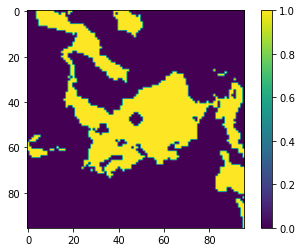

In [11]:
import matplotlib.pyplot as plt
plt.imshow(mask)
plt.colorbar()

In [12]:
from tensorflow.keras.models import load_model
import copy

mask_m = np.expand_dims(mask, axis = -1)
mask_m = np.expand_dims(mask_m, axis = 0)

# load saved weight and make prediction
def prediction_one_step (model_lst = None, x_test_i = None, model_file = None):
    
    predict_test_lst = []
    for i in model_lst:
        our_model.load_weights(model_file+str(i)+".h5") 
        x_test_i = np.array(x_test_i)

        predicted_test = our_model.predict([x_test_i])

        predict_test_lst.append(predicted_test)
    
    predict_test_lst = np.array(predict_test_lst) 
    predict_test_lst = np.mean(predict_test_lst, axis = 0)

    return predict_test_lst


In [13]:
# reshape the result to target(y) and lead time(x)

def reshape_based_leadtime (y_matrix):
    
    #sample numbers
    lead_time = y_matrix.shape[3]
    all_samples = []
    for row in range(y_matrix.shape[0] - lead_time+1):
        
        cur_target = []
        for j in reversed(range(lead_time)):#leadtime 5
            cur_target.append(y_matrix[row+j,:,:,lead_time-(j+1)])
            
        
        cur_target = np.array(cur_target)
        #print(cur_target.shape)
    
        all_samples.append(cur_target) 
              
    all_samples = np.array(all_samples)    
        
    return all_samples

In [14]:
model_list = [1,2,3] # three models for each instance
all_y_pred = []
all_y_test = []

all_y_test_SIE = []
all_y_pred_SIE = []

# name flag of saved model
model_flage = "valspt0.2_sit3_sic6_sicanom3_yclim_x6y6_128_4_sn1_w4_nh2_mn128256"

# generating test data year by year
for test_i in range (20, 0, -1):
    
    test_year = test_i
    lead_time_steps = y_length - 1 
    test_flag = test_year * biweek_per_year + lead_time_steps
    smaples_pery = biweek_per_year+lead_time_steps 
        
    x_clo_sic_test = x_clo_sic[-test_flag:-test_flag+smaples_pery, :, :, :] # 
    y_sic_test = y_sic[-test_flag:-test_flag+smaples_pery:, :, :, :]
    
    if (test_year == 1):
        x_clo_sic_test = x_clo_sic[-test_flag:, :, :, :] # 
        y_sic_test = y_sic[-test_flag:, :, :, :]
        
    #y_sic_test = y_sic_test
    print(y_sic_test.shape)
    y_test = reshape_based_leadtime(y_sic_test)
    print("====reshape y_test====")
    print(y_test.shape)
 
    # set model's path for each testing year
    model_path = PATH + "SwinUNet_202310"+model_flage+str(2019-test_i+1)+"_"# 
    predict_all_steps_y = prediction_one_step(model_list, x_clo_sic_test, model_path)
    predict_all_steps_y[predict_all_steps_y<0.001] = 0

    p_test = predict_all_steps_y
    p_test = reshape_based_leadtime(p_test)

    y_test_cp = copy.deepcopy(y_test)
    y_pred_cp = copy.deepcopy(p_test)
        
    y_test_cp[y_test_cp>0.15] = 1
    y_pred_cp[y_pred_cp>0.15] = 1
        
    y_test_cp[y_test_cp<=0.15] = 0
    y_pred_cp[y_pred_cp<=0.15] = 0
        
    y_test_sie = np.sum(y_test_cp, axis = (-2,-1))
    y_pred_sie = np.sum(y_pred_cp, axis = (-2,-1))

    all_y_test.append(y_test)
    all_y_pred.append(p_test)
    
    all_y_test_SIE.append(y_test_sie)
    all_y_pred_SIE.append(y_pred_sie)
        
all_y_test = np.array(all_y_test)    
all_y_pred = np.array(all_y_pred)    

all_y_test_SIE = np.array(all_y_test_SIE)
all_y_pred_SIE = np.array(all_y_pred_SIE)

(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)


2024-11-27 02:01:27.272051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-11-27 02:01:27.272670: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2024-11-27 02:01:28.709104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-11-27 02:01:29.662276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-11-27 02:01:29.697862: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-11-27 02:01:30.587644: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2024-11-27 02:01:31.518959: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-27 02:01:31.519338: W tensorflow/stream_e

(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 96, 6)
====reshape y_test====
(12, 6, 96, 96)
(17, 96, 9

In [ ]:

# if you do not want to load the well-trained model to make evualte, you can load the predicted results of SICNetseason and the ground values from the following code.
#all_y_pred = np.load("./Data/Output data/Predicted_SIC_output.npy")
#all_y_test = np.load("./Data/Output data/Ground_SIC_output.npy")

In [15]:
print(all_y_test.shape)
print(all_y_pred.shape)

(20, 12, 6, 96, 96)
(20, 12, 6, 96, 96)


In [16]:
print(all_y_test_SIE.shape)
print(all_y_pred_SIE.shape)

(20, 12, 6)
(20, 12, 6)


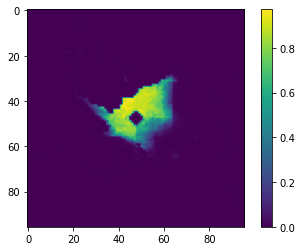

In [17]:
import matplotlib.pyplot as plt
plt.imshow(all_y_pred[-1,8,0,:,:])
plt.colorbar()

In [18]:
all_y_test = all_y_test.swapaxes(2, 4)
all_y_pred = all_y_pred.swapaxes(2, 4)

all_y_test = all_y_test.swapaxes(2, 3)
all_y_pred = all_y_pred.swapaxes(2, 3)

In [19]:
print(all_y_test.shape)
print(all_y_pred.shape)

(20, 12, 96, 96, 6)
(20, 12, 96, 96, 6)


In [20]:
all_y_test = all_y_test * mask_m
all_y_pred = all_y_pred * mask_m

In [25]:
print(all_y_test.shape)
print(all_y_pred.shape)

(20, 12, 96, 96, 6)
(20, 12, 96, 96, 6)


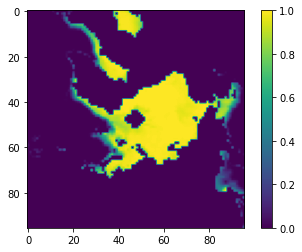

In [27]:
import matplotlib.pyplot as plt
plt.imshow(all_y_test[0,0,:,:,1])
plt.colorbar()

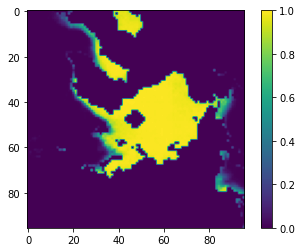

In [28]:
import matplotlib.pyplot as plt
plt.imshow(all_y_pred[0,0,:,:,1], vmin=0, vmax=1)
plt.colorbar()

In [29]:
y_test_SIE_mean = np.mean(all_y_test_SIE, axis = 0)
y_pred_SIE_mean = np.mean(all_y_pred_SIE, axis = 0)

In [30]:
y_test_SIE_mean = np.expand_dims(y_test_SIE_mean, axis = 0)
y_pred_SIE_mean = np.expand_dims(y_pred_SIE_mean, axis = 0)

In [31]:
print(y_test_SIE_mean.shape)
print(y_test_SIE_mean.shape)

(1, 12, 6)
(1, 12, 6)


In [32]:
y_test_SIE_anom = all_y_test_SIE - y_test_SIE_mean
y_pred_SIE_anom = all_y_pred_SIE - y_pred_SIE_mean

In [33]:
print(y_test_SIE_anom.shape)
print(y_pred_SIE_anom.shape)

(20, 12, 6)
(20, 12, 6)


## detrend

In [34]:
from scipy import signal

y_pred_SIE_anom_dtrend = signal.detrend(all_y_pred_SIE, axis=0, type='linear', bp=0, overwrite_data=False)
y_test_SIE_anom_dtrend = signal.detrend(all_y_test_SIE, axis=0, type='linear', bp=0, overwrite_data=False)


In [35]:
y_pred_SIE_anom = y_pred_SIE_anom_dtrend
y_test_SIE_anom = y_test_SIE_anom_dtrend

In [36]:
# read activate regions
activate_regions = np.load("Data/Activate_regions_monthly_brist.npy")

# function to calculate BACC
def Calculate_BACC(y_ground, y_pred):
    
    year_numb = y_ground.shape[0]
    month_ver = y_ground.shape[1]
    leadt_hor = y_ground.shape[4]
    
    all_bacc_matrix = np.zeros((year_numb, month_ver,leadt_hor),dtype=np.float64)
    
    cur_predit_sic = copy.deepcopy(y_pred)
    cur_ground_sic = copy.deepcopy(y_ground)
    
    cur_predit_sic[cur_predit_sic>0.15] = 1
    cur_ground_sic[cur_ground_sic>0.15] = 1
    
    cur_predit_sic[cur_predit_sic<=0.15] = 0
    cur_ground_sic[cur_ground_sic<=0.15] = 0
   
    for y in range(year_numb):

        for v in range(month_ver):
        
            for i in range(leadt_hor): 
                
                cur_pred_sie = cur_predit_sic[y,v,:,:,i]
                cur_true_sie = cur_ground_sic[y,v,:,:,i]
                
                cur_iiee = np.sum(np.abs(cur_pred_sie-cur_true_sie))
                cur_bacc = 1-cur_iiee/activate_regions[v]
                
                all_bacc_matrix [y,v,i] = cur_bacc
                
    return all_bacc_matrix

In [37]:
import scipy.stats as stats

# function to calculate ACC of SIE
def calculate_acc_SIE(ground_anomly_self, predict_anomly_self):
    
    all_person_cf = []
    all_person_cf_p = []
    all_person_cf_p_self = []
    
    row_n = ground_anomly_self.shape[-2]
    col_n = ground_anomly_self.shape[-1]
    
    cur_per = np.zeros((row_n,col_n),dtype=np.float64)
   
    for j in range(row_n):
            for k in range(col_n):
                cur_ground_self = ground_anomly_self[:,j,k]
                cur_predict_self = predict_anomly_self[:,j,k]
                    
                cur_ground_self = np.asarray(cur_ground_self).flatten()
                cur_predict_self = np.asarray(cur_predict_self).flatten()
                    
                person_self = stats.pearsonr(cur_predict_self, cur_ground_self)
                cur_per[j,k] = person_self[0]
                
    return  np.array(cur_per)




In [38]:
# calculate BACC and ACC of SIE
cur_bacc_matrix = Calculate_BACC(all_y_test, all_y_pred)
cur_acc_SIE = calculate_acc_SIE(y_test_SIE_anom, y_pred_SIE_anom)
BACC_3D_mean = np.mean(cur_bacc_matrix, axis = 0)


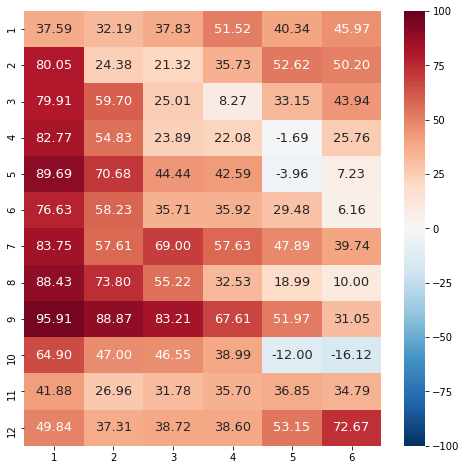

In [39]:
import seaborn as sns

import pandas as pd
columns_lst = range(1,y_length+1)
row_index = range(1,biweek_per_year+1)
bacc = np.round(cur_acc_SIE*100, 2)
df = pd.DataFrame(data = bacc, index = row_index, columns = columns_lst)
#fig, ax_arr = plt.subplots(1,1, figsize=(4,8.5))
sns.set_context({"figure.figsize":(8,8)})
ax = sns.heatmap(df, vmin = -100, vmax = 100, cmap = 'RdBu_r', annot=True, fmt=".2f", annot_kws={"size":13})


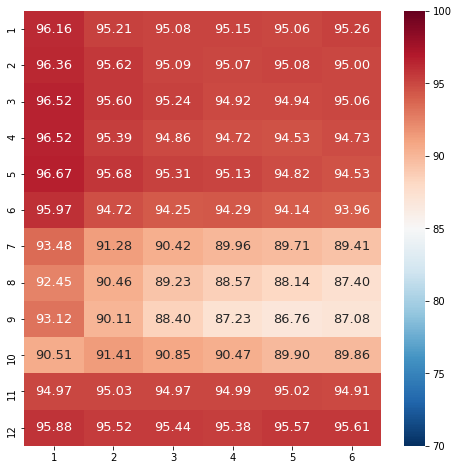

In [40]:
import seaborn as sns
import pandas as pd

columns_lst = range(1,y_length+1)
row_index = range(1,biweek_per_year+1)
bacc = np.round(BACC_3D_mean*100, 2)
df = pd.DataFrame(data = bacc, index = row_index, columns = columns_lst)
#fig, ax_arr = plt.subplots(1,1, figsize=(4,8.5))
sns.set_context({"figure.figsize":(8,8)})
ax = sns.heatmap(df, vmin = 70, vmax = 100, cmap = 'RdBu_r', annot=True, fmt=".2f", annot_kws={"size":13})
